In [1]:
""" Auto Encoder Example.
Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""

' Auto Encoder Example.\nUsing an auto encoder on MNIST handwritten digits.\nReferences:\n    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based\n    learning applied to document recognition." Proceedings of the IEEE,\n    86(11):2278-2324, November 1998.\nLinks:\n    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/\n'

In [2]:
#kg:
#import common/utils.ipynb notebook, which houses the ipywidget ProgtressImageWidget used for plotting
#also, common/utils.ipynb  contains the Plotter helper class
from inspect import getsourcefile
import os.path
import sys
current_path = os.path.abspath(getsourcefile(lambda:0))
parent_dir = os.path.split(os.path.dirname(current_path))[0]
sys.path.insert(0, parent_dir)
import common.load_notebooks
import common.utils

importing Jupyter notebook from /home/ec2-user/tf/projects/TensorFlow-Examples/notebooks/common/utils.ipynb


<IPython.core.display.Javascript object>

In [3]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
# Parameters

learning_rate = 0.01
training_epochs = 20
batch_size = 128
display_step = 1
examples_to_show = 10
#kg: added  a random seed
random_seed=42

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

#kg:
#set random seed
tf.set_random_seed(random_seed)
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

#kg: handy general initialization function
#
def init_weights(shape, init_method='xavier', seed=42, xavier_params = (None, None)):
    if init_method=='zeros':
        return tf.Variable(tf.zeros(shape, dtype=tf.float32))
    elif init_method == 'uniform':
        #kg: staddev 0.01 really reduced the cost from .1 to 0.009
        return tf.Variable(tf.random_normal(shape, stddev=0.01, dtype=tf.float32, seed=seed))
    elif init_method=='xavier':
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out))
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32, seed=seed))

#kg:xavier initialization of weights gives the lowest cost
init_method_weights='xavier'
init_method_bias='zeros'
weights = {
    'encoder_h1': init_weights([n_input, n_hidden_1], init_method=init_method_weights, seed=random_seed+1, xavier_params=(n_input, n_hidden_1)),
    'encoder_h2': init_weights([n_hidden_1, n_hidden_2], init_method=init_method_weights, seed=random_seed+1, xavier_params=(n_hidden_1, n_hidden_2)),
    'decoder_h1': init_weights([n_hidden_2, n_hidden_1], init_method=init_method_weights, seed=random_seed+3, xavier_params=(n_hidden_2, n_hidden_1)),
    'decoder_h2': init_weights([n_hidden_1, n_input], init_method=init_method_weights, seed=random_seed+4, xavier_params=(n_hidden_1, n_input)),
}
biases = {
    'encoder_b1': init_weights([n_hidden_1], init_method=init_method_bias, seed=random_seed+5),
    'encoder_b2': init_weights([n_hidden_2], init_method=init_method_bias, seed=random_seed+6),
    'decoder_b1': init_weights([n_hidden_1], init_method=init_method_bias, seed=random_seed+7),
    'decoder_b2': init_weights([n_input], init_method=init_method_bias, seed=random_seed+8)
}


In [5]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

Optimization Finished!, final cost is 0.00881006848067
Testing finished!, final mean cost for 10 test samples is  0.00923608057201


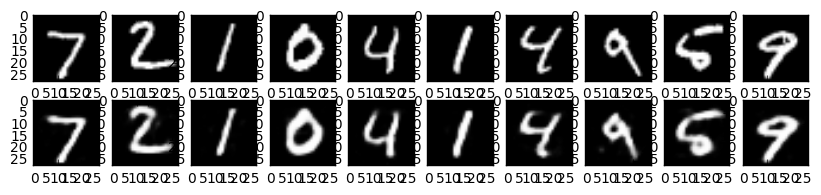

In [6]:
%matplotlib inline
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)

#kg: display the ProgressImageWidget
from IPython.display import display
p=common.utils.ProgressImageWidget()
display(p)
#kg: handy Plotter class
plotter = common.utils.Plotter(xlabel='no. of epochs',ylabel='loss', title='autoencoder loss')
plotter.add_channel(num_samples=int(np.floor(training_epochs/display_step)),
                        channel_name='train',
                        legend='train')

sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(mnist.train.num_examples/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    
    # Display logs per epoch step
    if epoch % display_step == 0:
        plotter.add_sample( epoch,  c, channel_name='train')
        p.value = plotter.plot()
        #print("Epoch:", '%04d' % (epoch+1),
        #      "cost=", "{:.9f}".format(c))

print("Optimization Finished!, final cost is {c}".format(c=c))

# Applying encode and decode over test set
c, encode_decode = sess.run(
    [cost, y_pred], feed_dict={X: mnist.test.images[:examples_to_show]})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)), cmap='gray')
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)), cmap='gray')
    
print("Testing finished!, final mean cost for {d} test samples is  {c}".format(d=examples_to_show, c=c))
#f.show()
#plt.draw()
#plt.waitforbuttonpress()

In [ ]:
# Result